İmporting and Run SparkSession

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Load Medium Dataset") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .getOrCreate()

spark.sparkContext.setLogLevel("INFO")

df = spark.read.csv("synthetic_fraud_dataset.csv", header=True, inferSchema=True)




Control of there is any gap in dataset 

In [2]:
from pyspark.sql.functions import col, count, when

total_rows = df.count()

doluluk_orani = (
    df.select(
        [
            (count(when(col(c).isNotNull(), c)) / total_rows * 100).alias(c)
            for c in df.columns
        ]
    )
)


<Figure size 1000x600 with 0 Axes>

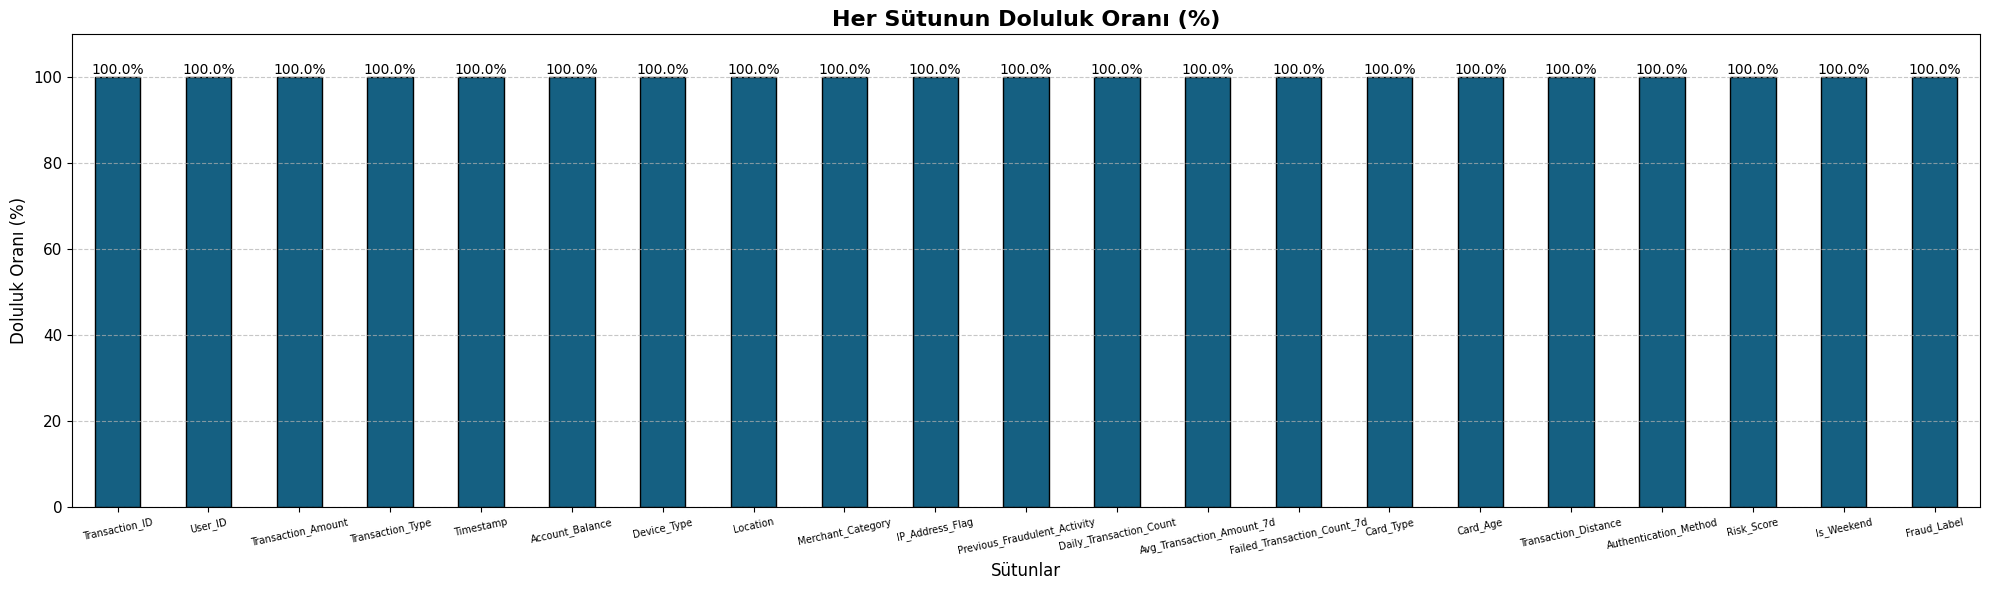

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

doluluk_orani_df = doluluk_orani.toPandas().T
doluluk_orani_df.columns = ['Doluluk Oranı (%)']
doluluk_orani_df.reset_index(inplace=True)
doluluk_orani_df.rename(columns={'index': 'Sütun'}, inplace=True)

plt.figure(figsize=(10, 6))
ax = doluluk_orani_df.plot(
    kind='bar', 
    x='Sütun', 
    y='Doluluk Oranı (%)', 
    color='#156082', 
    edgecolor='black', 
    legend=False, 
    figsize=(20, 6)
)

plt.title('Her Sütunun Doluluk Oranı (%)', fontsize=16, fontweight='bold')
plt.ylabel('Doluluk Oranı (%)', fontsize=12)
plt.xlabel('Sütunlar', fontsize=12)

plt.xticks(rotation=12, fontsize=7)
plt.yticks(fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.7)

for index, row in doluluk_orani_df.iterrows():
    ax.text(index, row['Doluluk Oranı (%)'], f"{row['Doluluk Oranı (%)']:.1f}%", ha='center', va='bottom', fontsize=10)

plt.ylim(0, doluluk_orani_df['Doluluk Oranı (%)'].max() * 1.1)
plt.tight_layout()
plt.show()


In [4]:
from pyspark.sql.functions import col

In [5]:
for column_name in df.columns:
    print(column_name)

Transaction_ID
User_ID
Transaction_Amount
Transaction_Type
Timestamp
Account_Balance
Device_Type
Location
Merchant_Category
IP_Address_Flag
Previous_Fraudulent_Activity
Daily_Transaction_Count
Avg_Transaction_Amount_7d
Failed_Transaction_Count_7d
Card_Type
Card_Age
Transaction_Distance
Authentication_Method
Risk_Score
Is_Weekend
Fraud_Label


Removing unnecessary columns from the data.

In [6]:
df_clean = df.drop("Transaction_ID")
df_clean = df_clean.drop("User_ID")
df_clean = df_clean.drop("Timestamp")

It consists of IP_Address_Flag , Previous_Fraudulent_Activity , Is_Weekend 1 and 0's.

It consists of Transaction_Type , Device_Type , Location , Merchant_Category , Card_Type , Authentication_Method texts.

It consists of Transaction_Amount , Account_Balance , Daily_Transaction_Count , Avg_Transaction_Amount_7d , Failed_Transaction_Count_7d , Card_Age , Transaction_Distance numbers.

Risk_Score decimal number.

Fraud_Label column to be learned consists of 1s and 0s.

In [7]:
from pyspark.sql.types import StringType

In [8]:
df.printSchema()

root
 |-- Transaction_ID: string (nullable = true)
 |-- User_ID: string (nullable = true)
 |-- Transaction_Amount: double (nullable = true)
 |-- Transaction_Type: string (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- Account_Balance: double (nullable = true)
 |-- Device_Type: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Merchant_Category: string (nullable = true)
 |-- IP_Address_Flag: integer (nullable = true)
 |-- Previous_Fraudulent_Activity: integer (nullable = true)
 |-- Daily_Transaction_Count: integer (nullable = true)
 |-- Avg_Transaction_Amount_7d: double (nullable = true)
 |-- Failed_Transaction_Count_7d: integer (nullable = true)
 |-- Card_Type: string (nullable = true)
 |-- Card_Age: integer (nullable = true)
 |-- Transaction_Distance: double (nullable = true)
 |-- Authentication_Method: string (nullable = true)
 |-- Risk_Score: double (nullable = true)
 |-- Is_Weekend: integer (nullable = true)
 |-- Fraud_Label: integer (nullable

In [9]:
for sutun in df_clean.schema:
    if sutun.dataType == StringType():
        print(sutun.name)

Transaction_Type
Device_Type
Location
Merchant_Category
Card_Type
Authentication_Method


For normalization and machine learning, the written columns with more than 1 feature are separated into feature columns one by one.

In [10]:
yeni_df = df_clean

sozel_sutunlar = [sutun.name for sutun in df_clean.schema if isinstance(sutun.dataType, StringType)]

for sutun_adi in sozel_sutunlar:
    benzersiz_degerler = [row[sutun_adi] for row in df_clean.select(sutun_adi).distinct().collect()]

    for aranan_deger in benzersiz_degerler:
        yeni_df = yeni_df.withColumn(
            f"{sutun_adi}_{aranan_deger}_MI",
            when(col(sutun_adi) == aranan_deger, 1).otherwise(0)
        )
        print(f"Tablo: {sutun_adi}_{aranan_deger}_MI")


Tablo: Transaction_Type_Bank Transfer_MI
Tablo: Transaction_Type_POS_MI
Tablo: Transaction_Type_ATM Withdrawal_MI
Tablo: Transaction_Type_Online_MI
Tablo: Device_Type_Laptop_MI
Tablo: Device_Type_Mobile_MI
Tablo: Device_Type_Tablet_MI
Tablo: Location_London_MI
Tablo: Location_Mumbai_MI
Tablo: Location_Sydney_MI
Tablo: Location_Tokyo_MI
Tablo: Location_New York_MI
Tablo: Merchant_Category_Groceries_MI
Tablo: Merchant_Category_Travel_MI
Tablo: Merchant_Category_Electronics_MI
Tablo: Merchant_Category_Clothing_MI
Tablo: Merchant_Category_Restaurants_MI
Tablo: Card_Type_Discover_MI
Tablo: Card_Type_Visa_MI
Tablo: Card_Type_Mastercard_MI
Tablo: Card_Type_Amex_MI
Tablo: Authentication_Method_PIN_MI
Tablo: Authentication_Method_OTP_MI
Tablo: Authentication_Method_Password_MI
Tablo: Authentication_Method_Biometric_MI


In [11]:
for sutun in yeni_df.schema:
    if sutun.dataType == StringType():
        yeni_df = yeni_df.drop(sutun.name)

Min-Max normalization is performed.

In [12]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

In [13]:
num_cols = [col for col in yeni_df.columns]

assembler = VectorAssembler(inputCols=num_cols, outputCol="features_vec")
df_vec = assembler.transform(yeni_df)

scaler = MinMaxScaler(inputCol="features_vec", outputCol="scaled_features")
scaler_model = scaler.fit(df_vec)
df_normalized = scaler_model.transform(df_vec)


Preparing for machine learning.

In [14]:
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

In [15]:
df_dense = df_normalized.withColumn("scaled_array", vector_to_array("scaled_features"))

for i, col_name in enumerate(num_cols):
    df_dense = df_dense.withColumn(f"{col_name}_scaled", col("scaled_array")[i])

In [16]:
df_final = df_dense.select(
    *[col("scaled_array")[i].alias(f"{num_cols[i]}_scaled") for i in range(len(num_cols))]
)

To test the dataset, split the dataset into 80% and 20%.

In [17]:
yuzde80, yuzde20 = df_final.randomSplit([0.8, 0.2], seed=42)

df_final = yuzde80  

yuzde20.toPandas().to_csv("test_dataset.csv", index=False)


Machine learning is performed with the artificial neural networks method.

In [18]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from pyspark.ml.feature import VectorAssembler

num_cols = df_final.columns 
num_cols.remove('Fraud_Label_scaled')  

assembler = VectorAssembler(inputCols=num_cols, outputCol="features")
df_vec = assembler.transform(df_final)

features = np.array(df_vec.select("features").rdd.map(lambda x: x[0].toArray()).collect())
labels = np.array(df_vec.select("Fraud_Label_scaled").rdd.map(lambda x: x[0]).collect())

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.21, random_state=41)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)), 
    tf.keras.layers.Dense(640, activation='relu'),  
    tf.keras.layers.Dense(320, activation='relu'),  
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Model Loss: {loss}, Model Accuracy: {accuracy}")


Epoch 1/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8387 - loss: 0.3394
Epoch 2/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9741 - loss: 0.0609
Epoch 3/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9799 - loss: 0.0497
Epoch 4/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9806 - loss: 0.0461
Epoch 5/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9842 - loss: 0.0372
Epoch 6/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9867 - loss: 0.0336
Epoch 7/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9870 - loss: 0.0308
Epoch 8/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9875 - loss: 0.0310
Epoch 9/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9893 - loss: 0.0286
Epoch 10/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9909 - loss: 0.0241
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9856 - loss: 0.0317
Model Loss: 0.032879412174224854, Model Accuracy: 0.985273182392

Confusion matrix:

264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step


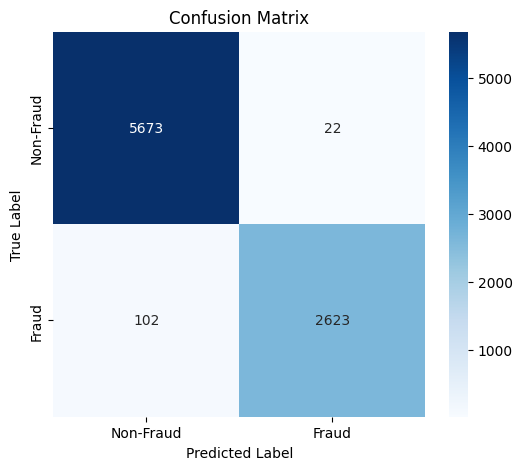

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      5695
         1.0       0.99      0.96      0.98      2725

    accuracy                           0.99      8420
   macro avg       0.99      0.98      0.98      8420
weighted avg       0.99      0.99      0.99      8420



In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred_probs = model.predict(X_test)  
y_pred = (y_pred_probs > 0.5).astype(int)  

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred))


Model saving and install test data.

In [20]:
df_test = spark.read.csv("test_dataset.csv", header=True, inferSchema=True)

In [21]:
import keras
keras.saving.save_model(model, 'fraud_detection_model.keras')

In [22]:
from keras.saving import load_model

In [23]:
model = load_model('fraud_detection_model.keras')

In [24]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=num_cols, outputCol="features")
df_vec = assembler.transform(df_test)


Testing the model.

In [25]:
test_features = np.array(df_vec.select("features").rdd.map(lambda x: x[0].toArray()).collect())
test_labels = np.array(df_vec.select("Fraud_Label_scaled").rdd.map(lambda x: x[0]).collect())

In [26]:
y_pred = model.predict(test_features)

y_pred_class = (y_pred > 0.5).astype(int)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels, y_pred_class)

print(f"Model doğruluğu: {accuracy:.4f}")

310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
Model doğruluğu: 0.9868
